In [8]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.mixture import GaussianMixture
from inference.compute_test_features import load_scenario_features, get_array_features, get_ego_features
from inference.visualization import DataVisualization
from inference.performance_statistics import *
from inference.read_report import ReportProcessor
from inference.compute_post_scores import ComputePostScore
from scipy.spatial import distance
import pandas as pd
from torch.distributions.multivariate_normal import MultivariateNormal
from omegaconf import DictConfig 
import hydra
from hydra.utils import instantiate

from resample_train_scenario import *
import yaml
os.environ['PLANTF'] = '/home/sgwang/planTF'
class EncoderFeatureAnalyzer:
    def __init__(self):
        dim =128
        self.norm = nn.LayerNorm(dim)
        
    def load_encoder_features(self, folder_path):
        encoder_features = []
        
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.pt'):
                file_path = os.path.join(folder_path, file_name)
                try:
                    features = torch.load(file_path)
                    encoder_features.append(features)
                except Exception as e:
                    print(f"Failed to load {file_path}: {e}")

        return encoder_features
    
    def get_ego_features(self, features):
        ego_features = []
        for feature in features:
            feature = feature[:,0]
            ego_features.append(feature)
        return ego_features
    
    def split_and_concat_features(self, features):
        # Convert to tensor
        # Split the tensor into a list of tensors each of size [128]
        all_features = []
        for feature in features:
            split_features = feature.split(1, dim=0)
            split_features = [f.squeeze(0) for f in split_features]
            all_features.extend(split_features)
        # Concatenate all tensors together as [:, 128]
        concatenated_features = torch.stack(all_features)
        return concatenated_features
    
    def get_other_features(self, features):
        other_features = []
        for feature in features:
            feature = feature[:,1:]
            other_features.append(feature)
        return other_features
    
    def compute_mean(self, features):
        means = []
        for feature in features:
            mean = torch.mean(feature, dim=0)
            means.append(mean)
        return means
    
    def compute_std(self, features):
        stds = []
        for feature in features:
            std = torch.std(feature, dim=0)
            stds.append(std)
        return stds
    
    def compute_min(self, features):
        mins = []
        for feature in features:
            min_val = torch.min(feature, dim=0).values
            mins.append(min_val)
        return mins
    
    def compute_max(self, features):
        maxs = []
        for feature in features:
            max_val = torch.max(feature, dim=0).values
            maxs.append(max_val)
        return maxs
    
    def concat_features(self, features):
        concat_features = []
        for feature in features:
            feature = feature.view(-1)
            concat_features.append(feature)
        return concat_features

    def compute_norm(self, features):
        norms = []
        for feature in features:
            encoder_feature = feature.clone().detach().cpu()
            x = self.norm(encoder_feature)
            norms.append(x)
        return norms
    
    def compute_gmm(self, features):
        gmm = GaussianMixture(n_components=2)
        gmm.fit(features)
        return gmm
    
    def colculate_matrix(self, features):
        mean = np.mean(features, axis=0)
        cov_matrix = np.cov(features, rowvar=False)
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        return mean, cov_matrix, inv_cov_matrix
    

In [2]:
import torch
from sklearn.decomposition import PCA

def train_pca_and_cov(encoder_features, n_components):
    """
    训练阶段：对训练数据进行标准化，降维，并计算协方差矩阵和其逆。
    
    参数:
        encoder_features (torch.Tensor): 训练数据 (N x D)
        n_components (int): PCA 降维后的维度 (默认 20)
    
    返回:
        pca (PCA): 训练好的 PCA 模型
        mean (torch.Tensor): 降维后训练数据的均值 (1 x n_components)
        cov_inv (torch.Tensor): 协方差矩阵的逆 (n_components x n_components)
        original_mean (torch.Tensor): 原始数据的均值 (1 x D)
        original_std (torch.Tensor): 原始数据的标准差 (1 x D)
    """
    # 计算原始数据的均值和标准差进行标准化
    original_mean = torch.mean(encoder_features, dim=0)
    original_std = torch.std(encoder_features, dim=0)
    original_std[original_std == 0] = 1e-6  # 防止除以零
    encoder_features = (encoder_features - original_mean) / original_std

    # 确保数据在 CPU 上，并转换为 NumPy 格式
    if encoder_features.is_cuda:
        encoder_features = encoder_features.cpu()
    features_np = encoder_features.numpy()

    # 使用 PCA 对数据降维
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features_np)

    # 转换降维后的数据回 PyTorch tensor
    reduced_features = torch.tensor(reduced_features, dtype=torch.float32)

    # 计算降维后的均值和协方差矩阵
    mean = torch.mean(reduced_features, dim=0)  # 降维后的均值
    centered_features = reduced_features - mean  # 数据中心化
    cov = (centered_features.T @ centered_features) / (reduced_features.shape[0] - 1)  # 协方差矩阵

    # 正则化协方差矩阵并计算其逆
    epsilon = 1e-6
    cov += epsilon * torch.eye(cov.shape[0])
    cov_inv = torch.linalg.inv(cov)

    return pca, mean, cov_inv, original_mean, original_std

# 方法 2: 推理阶段，计算单个新样本的马氏距离
def compute_mahalanobis_distance(new_sample, pca, mean, cov_inv, original_mean, original_std):
    """
    推理阶段：计算单个新样本的马氏距离。
    
    参数:
        new_sample (torch.Tensor): 新样本 (1 x D)
        pca (PCA): 训练好的 PCA 模型
        mean (torch.Tensor): 降维后训练数据的均值
        cov_inv (torch.Tensor): 协方差矩阵的逆
        original_mean (torch.Tensor): 原始数据的均值
        original_std (torch.Tensor): 原始数据的标准差
    
    返回:
        float: 新样本的马氏距离
    """
    # 对新样本进行标准化
    new_sample = (new_sample - original_mean) / original_std

    # 使用 PCA 对新样本降维
    new_sample_np = new_sample.numpy()
    new_sample_reduced = pca.transform(new_sample_np.reshape(1, -1))  # 降维
    new_sample = torch.tensor(new_sample_reduced, dtype=torch.float32)

    # 计算马氏距离
    diff = new_sample - mean  # 新样本与降维后均值的偏差
    mahalanobis_distance = torch.sqrt(diff @ cov_inv @ diff.T)
    return mahalanobis_distance.item()

def get_distance(scenario, concatenated_features, n_components):
    scenario_name = list(scenario.keys())[0]
    scenario_feature = list(scenario.values())[0]
    array_features = get_array_features(scenario_feature)
    ego_features = get_ego_features(array_features)
    encoder_features = concatenated_features  
    pca, mean, cov_inv, original_mean, original_std = train_pca_and_cov(encoder_features, n_components)
    distances = []
    for ego_feature in ego_features:
        ego_feature = torch.tensor(ego_feature)
        mahalanobis_distance = compute_mahalanobis_distance(
            ego_feature,  pca, mean, cov_inv, original_mean, original_std
        )
        distances.append(mahalanobis_distance)
    mean_distance = sum(distances) / len(distances)
    return scenario_name,mean_distance, distances

In [3]:
analyzer = EncoderFeatureAnalyzer()
plantf_path = os.getenv('PLANTF')
norm_path = os.path.join(plantf_path, 'ego_features')
norm_features = analyzer.load_encoder_features(norm_path)
# norm_features = analyzer.get_ego_features(norm_features)
concatenated_features = analyzer.split_and_concat_features(norm_features)
scenario_path = os.path.join(plantf_path, 'encoder_features')
scenarios =load_scenario_features(scenario_path)
results = []  
for scenario in scenarios:
    scenario_name, mean_distance, distances = get_distance(scenario, concatenated_features,  n_components=30)
    results.append({
        "scenario_name": scenario_name,
        "Mean Distance": mean_distance,
        "Distances": distances
    })
results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)

In [ ]:
analyzer = EncoderFeatureAnalyzer()
plantf_path = os.getenv('PLANTF')
norm_path = os.path.join(plantf_path, 'ego_features')
norm_features = analyzer.load_encoder_features(norm_path)
concatenated_features = analyzer.split_and_concat_features(norm_features)

scenario_path = os.path.join(plantf_path, 'encoder_features')
scenarios = load_scenario_features(scenario_path)

#n_components
for n_components in range(10, 51, 5):  # from 10 to 50  
    results = []  # store results for all scenarios
    # Compute Mahalanobis distance for each scenario
    for scenario in scenarios:
        scenario_name, mean_distance, distances = get_distance(scenario, concatenated_features, n_components=n_components)
        results.append({
            "Scenario Name": scenario_name,
            "Mean Distance": mean_distance,
            "Distances": distances
        })

    results_df = pd.DataFrame(results)
 
    output_file = f'results_n_components_{n_components}.csv'
    results_df.to_csv(output_file, index=False)

    print(f"Results for n_components={n_components} saved to {output_file}")

In [4]:
def load_scenario_types(yaml_file):
    with open(yaml_file, 'r') as file:
        data = yaml.safe_load(file)  
    return set(data['scenario_types'])  

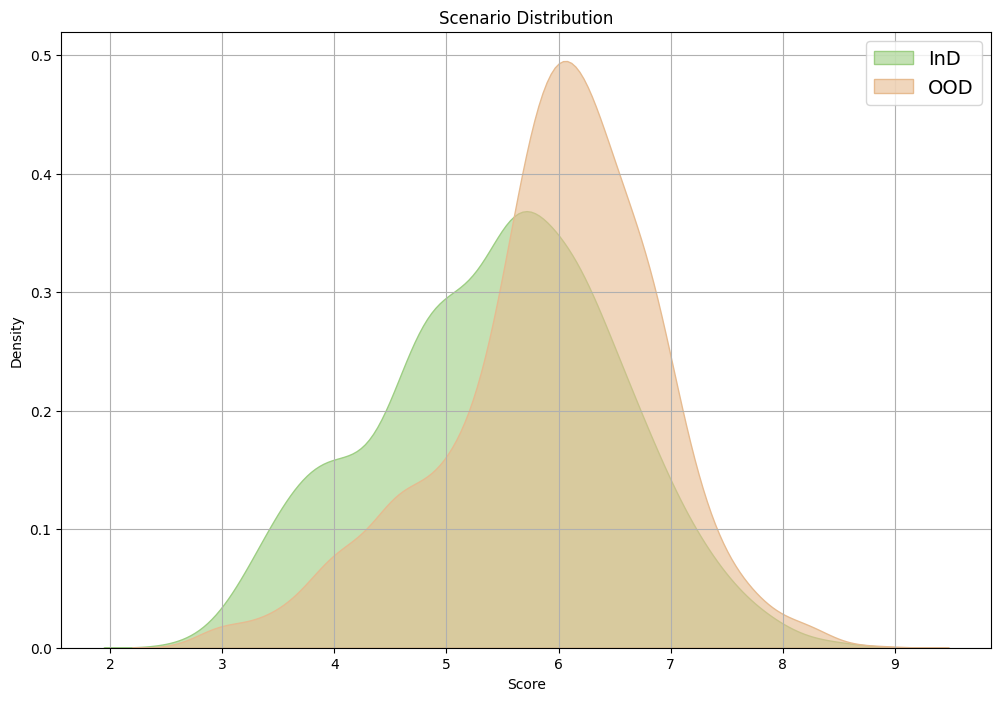

In [9]:
CONFIG_PATH = 'inference/config'
CONFIG_NAME = 'runner_report'
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)
cfg = hydra.compose(config_name=CONFIG_NAME,overrides=['split=test_all','planner=inferenceTF', 'job_name=open_loop_boxes'])
processor = ReportProcessor(cfg)
result_df = processor.read_metric_reports()
InD_scenarios= load_scenario_types('InD.yaml')
labeled_df = label_scenarios(result_df, InD_scenarios) 
distance_df = pd.read_csv('results.csv')
merged_df = pd.merge(distance_df, labeled_df, on="scenario_name", how="inner")
visualizer = DataVisualization(figsize=(12, 8), alpha=0.6, grid=True)
visualizer.draw_distribution (merged_df, score='Mean Distance')

In [ ]:
import torch
def compute_cov(encoder_features):
    """
    参数:
        encoder_features (torch.Tensor):   (N x D)
    return:
        cov_inv (torch.Tensor): (D x D)
        original_mean (torch.Tensor):  (1 x D)
        original_std (torch.Tensor): (1 x D)
    """
    mean = torch.mean(encoder_features, dim=0)
    std = torch.std(encoder_features, dim=0)
    std[std == 0] = 1e-6  
    encoder_features = (encoder_features - mean) / std
    centered_features = encoder_features - mean  
    cov = (centered_features.T @ centered_features) / (encoder_features.shape[0] - 1)  
    epsilon = 1e-6
    cov += epsilon * torch.eye(cov.shape[0])
    cov_inv = torch.linalg.inv(cov)

    return   cov_inv, mean, std
 
def compute_mahalanobis_distance(new_sample, mean, cov_inv, std):
    """
    compute： compute the mahalanobis distance of the new sample
    
    parameters:
        new_sample (torch.Tensor):  (1 x D）
        cov_inv (torch.Tensor):  (D x D)
        mean (torch.Tensor):  (1 x D)
        std (torch.Tensor):   (1 x D)
    
    return:
        float: distance
    """

    new_sample = (new_sample - mean) / std
    diff = new_sample - mean 
    mahalanobis_distance = torch.sqrt(diff @ cov_inv @ diff.T)
    return mahalanobis_distance.item()

def get_distance(scenario, concatenated_features):
    scenario_name = list(scenario.keys())[0]
    scenario_feature = list(scenario.values())[0]
    array_features = get_array_features(scenario_feature)
    ego_features = get_ego_features(array_features)
    encoder_features = concatenated_features  
    cov_inv, original_mean, original_std = compute_cov(encoder_features)
    distances = []
    for ego_feature in ego_features:
        ego_feature = torch.tensor(ego_feature)
        mahalanobis_distance = compute_mahalanobis_distance(
            ego_feature, original_mean, cov_inv, original_std
        )
        distances.append(mahalanobis_distance)
    mean_distance = sum(distances) / len(distances)
    return scenario_name,mean_distance, distances

In [ ]:
analyzer = EncoderFeatureAnalyzer()
plantf_path = os.getenv('PLANTF')
norm_path = os.path.join(plantf_path, 'ego_features')
norm_features = analyzer.load_encoder_features(norm_path)
# norm_features = analyzer.get_ego_features(norm_features)
concatenated_features = analyzer.split_and_concat_features(norm_features)
scenario_path = os.path.join(plantf_path, 'encoder_features')
scenarios =load_scenario_features(scenario_path)
results = []  
for scenario in scenarios:
    scenario_name, mean_distance, distances = get_distance(scenario, concatenated_features)
    results.append({
        "scenario_name": scenario_name,
        "Mean Distance": mean_distance,
        "Distances": distances
    })
results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)